In [90]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
#import useful libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import randint
import time
from datetime import datetime
from functions import *

In [92]:
data = pd.read_csv('bank_transactions.csv', delimiter=',')

In [4]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


# Finding Similar Customers

## 1.1 Set up the date

clean the dataset

In [93]:
#check for any NA values
any(data.isna())
data.dropna(inplace=True)

convert string to datetime

In [94]:
#convert into datetime format
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)
data.TransactionDate = pd.to_datetime(data.TransactionDate)

data.drop(data[data.CustomerDOB.dt.year > 1998].index, axis = 0, inplace = True)

data.drop(data[data.CustomerDOB == 1800].index, axis = 0, inplace=True)

data = data.reset_index()

We are going to keep only the rows We are going to use later in the query. Thus, we are going to get rid of *TransactionID* and *CustomerID*

In [95]:
data = data[['CustomerDOB','CustGender','CustLocation','CustAccountBalance','TransactionDate','TransactionTime','TransactionAmount (INR)']]

In [96]:
#get customer's age
data['CustomerDOB'] = data['CustomerDOB'].apply(lambda x: int(datetime.strftime(x, "%Y-%m-%w").split('-')[0]))
today = int(datetime.strftime(datetime.today().date(), "%Y-%m-%w").split('-')[0])
data['Age'] = data['CustomerDOB'].apply(lambda x: today - x)

In [97]:
#get weekday and hour in which transaction occurred
week_day = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
data['TransactionDay'] = data['TransactionTime'].apply(time.ctime)
data['Transaction_Hour'] = data['TransactionDay'].apply(lambda x : x[10:-4])
data['Transaction_weekday']     = data['TransactionDate'].apply(lambda x : week_day[pd.Timestamp(x).dayofweek])

In [98]:
#convert weekday into int value (e.g. Monday = 1)
data['Transaction_weekday'] = data['Transaction_weekday'].apply(lambda x: day_of_week(x))

#get the time range in which transaction happened (here time range is 2 hours long, e.g. 00:00:00-02:00:00)
data['Time_range'] = data['Transaction_Hour'].apply(lambda x: time_ranges(x))

In [99]:
data.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,TransactionDay,Transaction_Hour,Transaction_weekday,Time_range
0,1994,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,28,Fri Jan 2 16:46:47 1970,16:46:47,1,9
1,1996,F,MUMBAI,17874.44,2016-02-08,142712,459.0,26,Fri Jan 2 16:38:32 1970,16:38:32,1,9
2,1973,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,49,Fri Jan 2 16:38:34 1970,16:38:34,1,9
3,1988,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,34,Sat Jan 3 03:19:16 1970,03:19:16,1,2
4,1972,F,ITANAGAR,53609.20,2016-02-08,173940,676.0,50,Sat Jan 3 01:19:00 1970,01:19:00,1,1


In [100]:
#after the feature engineering let's drop some columns
data = data.drop(['CustomerDOB','TransactionDate', 'TransactionTime', 'TransactionDay', 'Transaction_Hour'], axis = 1)

In [101]:
data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,Transaction_weekday,Time_range
0,F,JAMSHEDPUR,17819.05,25.0,28,1,9
1,F,MUMBAI,17874.44,459.0,26,1,9
2,F,MUMBAI,866503.21,2060.0,49,1,9
3,F,NAVI MUMBAI,6714.43,1762.5,34,1,2
4,F,ITANAGAR,53609.20,676.0,50,1,1


In [102]:
#we save a copy of the dataframe that we will use later
data_cp = data.copy(deep=True)

Convert values in int32 dtype in order to apply the hash function

In [103]:
data.CustGender = data['CustGender'].apply(string_to_int)
data.CustLocation = data['CustLocation'].apply(string_to_int)
data.CustAccountBalance = data['CustAccountBalance'].apply(float_to_int)
data['TransactionAmount (INR)'] = data['TransactionAmount (INR)'].apply(float_to_int)


In [104]:
data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,Transaction_weekday,Time_range
0,70,755,17819,25,28,1,9
1,70,443,17874,459,26,1,9
2,70,443,866503,2060,49,1,9
3,70,777,6714,1762,34,1,2
4,70,583,53609,676,50,1,1


In [105]:
#obtain max value for x
data.max()

CustGender                       84
CustLocation                   2609
CustAccountBalance         55369688
TransactionAmount (INR)     1560034
Age                             222
Transaction_weekday               7
Time_range                       12
dtype: int64

In [106]:
#let's get the next prime number bigger than x

from sympy import nextprime

max_value_of_x = nextprime(55369688)

## 1.2 Fingerprint Hashing

The hash function we want to implement is in the following form: <br>
$\begin{equation} h(x)=(ax+b)\mod{c}\end{equation}$ <br>
where: <br>
- *x*: input value
- *a*, *b*: randomly choosen integers less than the maximum value of *x*
- *c*: the next prime number bigger than the maximum value of *x*

Now it's time to implement the MinHash

In [107]:
c = max_value_of_x
M = 2**32 -1                           
n_hash = 10

a,b = random_coef(n_hash, M)

list_of_tuples = list(
    map(
        lambda x, y: (x, y),
        a,
        b
    )
)
data['min-hash']  = [min_hash([*x[1]],c,list_of_tuples) for x in (data.iterrows())]

In [108]:
data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,Transaction_weekday,Time_range,min-hash
0,70,755,17819,25,28,1,9,"[11040451, 678229, 2235825, 2821352, 2108599, ..."
1,70,443,17874,459,26,1,9,"[11040451, 8608876, 453510, 2563973, 437145, 6..."
2,70,443,866503,2060,49,1,9,"[11040451, 8608876, 3913906, 9336397, 7855981,..."
3,70,777,6714,1762,34,1,2,"[11040451, 3313423, 4774426, 6358841, 7601169,..."
4,70,583,53609,676,50,1,1,"[11040451, 13731951, 2690495, 5950415, 5678579..."


## 1.3 Locality Sensitive Hashing (LSH)

Now let's apply the same idea on the query, and then apply the Jaccard similarity since MinHash is stricly related to it

In [131]:
query = pd.read_csv('query_users.csv')

In [132]:
query.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


pre-processing of the query

In [133]:
#convert date into datetime format
query.CustomerDOB = pd.to_datetime(query.CustomerDOB)
query.TransactionDate = pd.to_datetime(query.TransactionDate)

In [134]:
#get customer's age
query['CustomerDOB'] = query['CustomerDOB'].apply(lambda x: int(datetime.strftime(x, "%Y-%m-%w").split('-')[0]))
today = int(datetime.strftime(datetime.today().date(), "%Y-%m-%w").split('-')[0])
query['Age'] = query['CustomerDOB'].apply(lambda x: today - x)

In [135]:
#get weekday and transaction hour
week_day = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
query['TransactionDay'] = query['TransactionTime'].apply(time.ctime)
query['Transaction_Hour'] = query['TransactionDay'].apply(lambda x : x[10:-4])
query['Transaction_weekday'] = query['TransactionDate'].apply(lambda x : week_day[pd.Timestamp(x).dayofweek])

In [136]:
query.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,TransactionDay,Transaction_Hour,Transaction_weekday
0,1978,M,DELHI,94695.61,2016-02-09,140310,65.0,44,Fri Jan 2 15:58:30 1970,15:58:30,Tue
1,1992,M,PANCHKULA,7584.09,2016-02-09,120214,6025.0,30,Fri Jan 2 10:23:34 1970,10:23:34,Tue
2,1991,M,PATNA,7180.60,2016-10-08,221732,541.5,31,Sat Jan 3 14:35:32 1970,14:35:32,Sat
3,1987,M,CHENNAI,56847.75,2016-08-29,144138,1000.0,35,Fri Jan 2 17:02:18 1970,17:02:18,Mon
4,1995,M,GURGAON,84950.13,2016-09-25,233309,80.0,27,Sat Jan 3 17:48:29 1970,17:48:29,Sun


In [137]:
query['Transaction_weekday'] = query['Transaction_weekday'].apply(lambda x: day_of_week(x))
query['Time_range'] = query['Transaction_Hour'].apply(lambda x: time_ranges(x))

In [138]:
query = query.drop(['CustomerDOB','TransactionDate', 'TransactionTime', 'TransactionDay', 'Transaction_Hour'], axis = 1)

In [139]:
query_cp = query.copy(deep=True)

In [140]:
query_cp.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,Transaction_weekday,Time_range
0,M,DELHI,94695.61,65.0,44,2,8
1,M,PANCHKULA,7584.09,6025.0,30,2,6
2,M,PATNA,7180.60,541.5,31,6,8
3,M,CHENNAI,56847.75,1000.0,35,1,9
4,M,GURGAON,84950.13,80.0,27,7,9


In [141]:

#convert other values into int32
query.CustGender = query['CustGender'].apply(string_to_int)
query.CustLocation = query['CustLocation'].apply(string_to_int)
query.CustAccountBalance = query['CustAccountBalance'].apply(float_to_int)
query['TransactionAmount (INR)'] = query['TransactionAmount (INR)'].apply(float_to_int)

In [121]:
query.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,Transaction_weekday,Time_range
0,77,358,94695,65,44,2,8
1,77,663,7584,6025,30,2,6
2,77,372,7180,541,31,6,8
3,77,502,56847,1000,35,1,9
4,77,531,84950,80,27,7,9


In [142]:
query['min-hash']  = [min_hash([*x[1]],c,list_of_tuples) for x in (query.iterrows())]

In [123]:
query.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,Transaction_weekday,Time_range,min-hash
0,77,358,94695,65,44,2,8,"[461559, 11899915, 3414210, 2356766, 4417968, ..."
1,77,663,7584,6025,30,2,6,"[461559, 1662786, 136784, 917563, 883958, 6497..."
2,77,372,7180,541,31,6,8,"[461559, 3469000, 3224676, 8970021, 1040441, 6..."
3,77,502,56847,1000,35,1,9,"[461559, 665009, 709613, 4960246, 11952089, 60..."
4,77,531,84950,80,27,7,9,"[461559, 1176192, 6006779, 5877961, 9526894, 3..."


Jaccard's similarity is defined as:
$J(A,B)=\dfrac{|A \cap B|}{|A \cup B|}$

Let's now compute the Jaccard Similarity between the query and the original dataframe on the minhash

In [124]:
resultDF = pd.DataFrame(columns=['Query Index', 'Data Index-Jaccard Similarity'])

In [189]:
#Test with a threshold set to 0.6
result = {}

start = time.time()
threshold = 0.6
for idx_1, val_1 in enumerate(query['min-hash']):
    jaccard_list = []
    index_list = []
    for idx_2, val_2 in enumerate(data['min-hash']):
        if jaccard(val_1, val_2) > threshold:
            index_list.append(idx_2)
            jaccard_list.append(jaccard(val_1, val_2))
            result.update({idx_1: sorted(list(zip(index_list,jaccard_list)), key = lambda x: x[1], reverse=True)})
end = time.time() - start

In [191]:
#execution time expressed in seconds
print(end)

86.84473609924316


In [180]:
resultDF['Query Index'] = list(result.keys())
resultDF['Data Index-Jaccard Similarity'] = list(result.values())

In [179]:
resultDF

,Query Index,Data Index-Jaccard Similarity
0,0,"[(687184, 1.0), (76578, 0.75)]"
1,1,"[(670151, 1.0), (419461, 0.75), (946865, 0.75)]"
2,2,"[(290921, 1.0)]"
3,3,"[(588909, 1.0), (736637, 0.625)]"
4,4,"[(10697, 1.0), (429598, 0.625), (837934, 0.625)]"
5,5,"[(862651, 1.0), (869679, 0.75)]"
6,6,"[(569281, 1.0), (139122, 0.75), (139345, 0.75)..."
7,7,"[(73174, 1.0), (210548, 0.75), (329966, 0.75),..."
8,8,"[(551951, 1.0), (561493, 0.75)]"
9,10,"[(116689, 1.0), (480784, 1.0), (193334, 0.75),..."


In [194]:
#Test with a threshold set to 0.7
result = {}
threshold = 0.7

start = time.time()
for idx_1, val_1 in enumerate(query['min-hash']):
    jaccard_list = []
    index_list = []
    for idx_2, val_2 in enumerate(data['min-hash']):
        if jaccard(val_1, val_2) > threshold:
            index_list.append(idx_2)
            jaccard_list.append(jaccard(val_1, val_2))
            result.update({idx_1: sorted(list(zip(index_list,jaccard_list)), key = lambda x: x[1], reverse=True)})
end = time.time() - start

In [195]:
#execution time expressed in seconds
end

87.40046095848083

In [125]:
#Test with a threshold set to 0.8
result = {}

threshold = 0.8

start = time.time()
for idx_1, val_1 in enumerate(query['min-hash']):
    jaccard_list = []
    index_list = []
    for idx_2, val_2 in enumerate(data['min-hash']):
        if jaccard(val_1, val_2) > threshold:
            index_list.append(idx_2)
            jaccard_list.append(jaccard(val_1, val_2))
            result.update({idx_1: list(zip(index_list,jaccard_list))})

end = time.time() - start

In [126]:
#execution time expressed in seconds
end

85.3985641002655

In [127]:
result

{0: [(687184, 1.0)],
 1: [(670151, 1.0)],
 2: [(290921, 1.0)],
 3: [(588909, 1.0)],
 4: [(10697, 1.0)],
 5: [(862651, 1.0)],
 6: [(569281, 1.0)],
 7: [(73174, 1.0)],
 8: [(551951, 1.0)],
 10: [(116689, 1.0), (480784, 1.0)],
 11: [(271982, 1.0)],
 12: [(524003, 1.0)],
 13: [(256712, 1.0)],
 14: [(856165, 1.0)],
 15: [(647405, 1.0)],
 16: [(141610, 1.0)],
 17: [(172417, 1.0)],
 18: [(793697, 1.0), (794774, 1.0)],
 19: [(54776, 1.0)],
 20: [(496318, 1.0)],
 22: [(274894, 1.0)],
 24: [(75876, 1.0)],
 25: [(153452, 1.0)],
 26: [(6288, 1.0)],
 27: [(783549, 1.0)],
 28: [(204008, 1.0)],
 29: [(642811, 1.0), (645368, 1.0), (646953, 1.0)],
 30: [(232484, 1.0)],
 32: [(400663, 1.0)],
 33: [(777177, 1.0)],
 34: [(861726, 1.0)]}

In [143]:
#double-check
query_cp.iloc[0,:]

CustGender                        M
CustLocation                  DELHI
CustAccountBalance         94695.61
TransactionAmount (INR)        65.0
Age                              44
Transaction_weekday               2
Time_range                        8
Name: 0, dtype: object

In [144]:
data_cp.iloc[687184,:]

CustGender                        M
CustLocation                  DELHI
CustAccountBalance         94695.61
TransactionAmount (INR)        65.0
Age                              44
Transaction_weekday               2
Time_range                        8
Name: 687184, dtype: object

## 2. Grouping customers together!

### 2.1 Getting your data + feature engineering

In [1]:
import pandas as pd
from datetime import datetime
from scipy import stats
import numpy as np

In [4]:
df = pd.read_csv('archive.zip') #reading the file 

In [5]:
df.dropna(inplace = True) #dropping Nan values 

In [6]:
#converting timestamps object in datetime objects 
df.CustomerDOB = pd.to_datetime(df.CustomerDOB)
df.TransactionDate = pd.to_datetime(df.TransactionDate)
df.TransactionTime = df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

Replace (Date of Birth == 1800) and (Date of Birth > 2010) with _NaN_ in order to not lose the other information

In [7]:
df["CustomerDOB"] = df["CustomerDOB"].dt.year.replace(1800, np.NaN).astype("datetime64[ns]")
df["CustomerDOB"] = df["CustomerDOB"].dt.year.replace(r"201\d+", np.NaN).astype("datetime64[ns]")

#### 2.1.2 Required features

In [8]:
# a) Number of transactions
nt = df.groupby('CustomerID').count().TransactionID.reset_index(name='NumTransactions')
new_feature = pd.DataFrame(nt)

In [9]:
# b) Number of transactions with a balance bigger than 100 USD
df.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)
ntbb = df[df.TransactionAmount > 100].groupby('CustomerID').count().TransactionID.reset_index(name='Ntbb')
new_feature = pd.merge(new_feature, ntbb, on = ['CustomerID', 'CustomerID'])

In [10]:
# c) Average amount of the transactions
aat = df.groupby('CustomerID').mean().TransactionAmount.reset_index(name='AveAmTransactions')
new_feature = pd.merge(new_feature, aat, on = ['CustomerID', 'CustomerID'])

In [11]:
# d) Average balance
ab = df.groupby('CustomerID').mean().CustAccountBalance.reset_index(name='Average Balance')
new_feature = pd.merge(new_feature, ab, on = ['CustomerID', 'CustomerID'])

In [12]:
# e) Average difference between the balance and the transaction amount for each customer
df['utilisation'] = df['CustAccountBalance'] - df['TransactionAmount'] #Utilisations negative
ut = df.groupby('CustomerID').mean().utilisation.reset_index(name='Utilisation')
new_feature = pd.merge(new_feature, ut, on = ['CustomerID', 'CustomerID'])

In [13]:
# f) Most common gender of the customer
mcg = df.groupby('CustomerID')['CustGender'].agg(lambda x: stats.mode(x)[0][0]).reset_index(name='MostCommonGender')
new_feature = pd.merge(new_feature, mcg, on = ['CustomerID', 'CustomerID'])

In [14]:
# h) Most frequent location of the customer 
mfl = df.groupby('CustomerID')['CustLocation'].agg(lambda x: stats.mode(x)[0][0]).reset_index(name='MostFreqLocation')
new_feature = pd.merge(new_feature, mfl, on = ['CustomerID', 'CustomerID'])

#### 2.1.3 New features

Our features:
1. Average age
2. Number of users
3. Quantiles over the account balance
4. Presence of transactions over 50'000
5. Transaction amount variance
6. Quantiles over the average transaction amount
7. Number of different places
8. Filter if the account has a transaction in the top 25 most frequent places
9. Presence of minors in the account
10. Mean hour for each customer
11. Most common hour for each customer
12. Number of women
13. Number of men
14. Max purchase
15. Min purchase
16. Avearage Transaction / Balance (%)
17. Min Balance
18. Max Balance
19. Presence of recurring transactions (same tr. amount)
20. Transaction Distance (in days)

In [15]:
# 1) Average age of CustomerID
df['CustAge'] = round(((df.TransactionDate - df.CustomerDOB) / np.timedelta64(1, 'Y')), 0)
average = df.groupby('CustomerID').mean().CustAge.reset_index(name='AverageAge')
new_feature = pd.merge(new_feature, average, on = ['CustomerID', 'CustomerID'])

In [16]:
# 2) Number of users per CustomerID
nu = df.groupby('CustomerID')['CustomerID'].count().reset_index(name='UsersPerCustomerID')
new_feature = pd.merge(new_feature, nu, on = ['CustomerID', 'CustomerID'])

In [17]:
# 3) Quantiles over the account balance distribution
q = list(df["CustAccountBalance"].quantile([0,.25,.50,.75,.95]))
new_feature["BalanceQuant"] = df.apply(lambda x: .95 if x.CustAccountBalance >= q[4] else .75 if x.CustAccountBalance >= q[3]\
                                     else .50 if x.CustAccountBalance >= q[2] else .25 if x.CustAccountBalance >= q[1] else 0, axis=1)

In [18]:
# 4) Presence of transactions over 50'000
new_feature["TrOver50k"]=df["CustomerID"].isin(df[df["TransactionAmount"]>=50000].CustomerID)

In [19]:
# 5) Transaction amount variance
tav = df.groupby('CustomerID').var().TransactionAmount.reset_index(name='VarAmTransactions')
new_feature = pd.merge(new_feature, tav, on = ['CustomerID', 'CustomerID'])

In [20]:
# 6) Quantiles over the average transaction amount
q = list(new_feature["AveAmTransactions"].quantile([0,.25,.50,.75,.95]))
new_feature["AveTrQuant"] = new_feature.apply(lambda x: .95 if x.AveAmTransactions >= q[4] else .75 if x.AveAmTransactions >= q[3]\
                                     else .50 if x.AveAmTransactions >= q[2] else .25 if x.AveAmTransactions >= q[1] else 0, axis=1)

In [21]:
# 7) Number of different places
diff = df.groupby("CustomerID").CustLocation.count().reset_index(name='DifferentLocations')
new_feature = pd.merge(new_feature, diff, on = ['CustomerID', 'CustomerID'])

In [22]:
# 8) Filter if the account has a transaction in the top 25 most frequent places
places = df.groupby("CustLocation").CustomerID.count().sort_values(ascending=False)
top_places = places.head(int(len(places)*0.25))
has_tx = df[df.apply(lambda x: x.CustLocation in top_places.index, axis=1)].CustomerID.unique()
new_feature["TopPlaces"] = df["CustomerID"].isin(has_tx)

In [23]:
# 9) Presence of minors in the account
new_feature["WithChildren"]=df["CustomerID"].isin(df[df["CustAge"]<18].CustomerID)

In [24]:
# 10) Mean hour for each customer
mh = df.groupby("CustomerID").TransactionTime.mean().apply(lambda x: x.hour).reset_index(name='MeanHour')
new_feature = pd.merge(new_feature, mh, on = ['CustomerID', 'CustomerID']) 

In [25]:
# 11) Most common hour for each customer
df["TrHour"] = df.apply(lambda x: x.TransactionTime.hour,axis=1)
moh = df.groupby("CustomerID").TrHour.agg(lambda x: pd.Series.mode(x).iloc[0]).reset_index(name='MostCommonHour')
new_feature = pd.merge(new_feature, moh, on = ['CustomerID', 'CustomerID']) 

In [26]:
# 12) Number of women
wn = df[df["CustGender"]=="F"].groupby("CustomerID").CustomerDOB.count().reset_index(name='NumOfWomen')
new_feature = pd.merge(new_feature, wn, on = ['CustomerID', 'CustomerID']) 

In [27]:
# 13) Number of men
mn = df[df["CustGender"]=="M"].groupby("CustomerID").CustomerDOB.count().reset_index(name='NumOfMen')
new_feature = pd.merge(new_feature, mn, on = ['CustomerID', 'CustomerID']) 

In [28]:
# 14) Max purchase
mxp =  df.groupby('CustomerID').TransactionAmount.max().reset_index(name='MaxTransaction')
new_feature = pd.merge(new_feature, mxp, on = ['CustomerID', 'CustomerID'])

In [29]:
# 15) Min purchase
mnp =  df.groupby('CustomerID').TransactionAmount.min().reset_index(name='MinTransaction')
new_feature = pd.merge(new_feature, mnp, on = ['CustomerID', 'CustomerID'])

In [30]:
# 16) Transaction / Balance (%)
df['TransactionBalance'] = (df['TransactionAmount'] * 100) / (df['CustAccountBalance']+df['TransactionAmount'])
atb =  df.groupby('CustomerID').TransactionBalance.mean().reset_index(name='Ave_Transaction/Balance')
new_feature = pd.merge(new_feature, atb, on = ['CustomerID', 'CustomerID'])

In [31]:
# 17) Min Balance
mnp =  df.groupby('CustomerID').CustAccountBalance.min().reset_index(name='MinBalance')
new_feature = pd.merge(new_feature, mnp, on = ['CustomerID', 'CustomerID'])

In [32]:
# 18) Max Balance
mnp =  df.groupby('CustomerID').CustAccountBalance.max().reset_index(name='MaxBalance')
new_feature = pd.merge(new_feature, mnp, on = ['CustomerID', 'CustomerID'])

In [33]:
# 19) Presence of recurring transactions
rec = df.groupby(["CustomerID","TransactionAmount"]).TransactionID.count().groupby("CustomerID").max().reset_index(name='RecurringTr')
new_feature = pd.merge(new_feature, rec, on = ['CustomerID', 'CustomerID'])

In [34]:
# 20) Transaction Distance (in days)
dif = df.sort_values(['CustomerID','TransactionDate'])\
           .groupby('CustomerID')['TransactionDate']\
           .diff().dt.days.fillna(0).rename("TrDayDiff")

new_feature.sort_values("CustomerID",inplace=True)
new_feature["TrDayDiff"] = dif

The result is a DataFrame with 27 features:

In [37]:
#new_feature.to_csv("new_feature.csv")
new_feature.columns

Index(['CustomerID', 'NumTransactions', 'Ntbb', 'AveAmTransactions',
       'Average Balance', 'Utilisation', 'MostCommonGender',
       'MostFreqLocation', 'AverageAge', 'UsersPerCustomerID', 'BalanceQuant',
       'TrOver50k', 'VarAmTransactions', 'AveTrQuant', 'DifferentLocations',
       'TopPlaces', 'WithChildren', 'MeanHour', 'MostCommonHour', 'NumOfWomen',
       'NumOfMen', 'MaxTransaction', 'MinTransaction',
       'Ave_Transaction/Balance', 'MinBalance', 'MaxBalance', 'RecurringTr',
       'TrDayDiff'],
      dtype='object')

# 2.2 Choose your features

In [54]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
import matplotlib.pyplot as plt

### 2.2.1 Preprocessing
Encoding categorical features:
```python
"""Save the mapping array"""
#enc = preprocessing.LabelEncoder()
np.save('array.npy', enc.classes_) # to save the mapping
enc.classes_ = np.load('array.npy') # for reuse
```

In [39]:
features = ["MostFreqLocation","MostCommonGender","TrOver50k","TopPlaces","WithChildren"]  # all non-numeric features
for f in features:
    enc = preprocessing.LabelEncoder()
    enc.fit(new_feature[f])
    new_feature[f] = enc.transform(new_feature[f])
    #np.save(f+'.npy', enc.classes_)

Here we try different methods to scale our data

In [41]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(new_feature.dropna().drop("CustomerID",axis=1))

In [48]:
scaler2 = MaxAbsScaler()
scaled2 = scaler2.fit_transform(new_feature.dropna().drop("CustomerID",axis=1))

In [55]:
scaler3 = RobustScaler()
scaled3 = scaler3.fit_transform(new_feature.dropna().drop("CustomerID",axis=1))

### 2.2.2 PCA
Checking which method achieves the best performance in the PCA

In [ ]:
new_feature.dropna().drop("CustomerID",axis=1)

MinMax Scaler

In [44]:
pca = PCA(n_components=2)
red_data = pca.fit_transform(scaled)
print("Variance:",sum(pca.explained_variance_ratio_))

Variance: 0.3713217293993548


MaxAbs Scaler

In [50]:
pca = PCA(n_components=2)
red_data = pca.fit_transform(scaled2)
print("Variance:",sum(pca.explained_variance_ratio_))

Variance: 0.42329431614149404


Robust Scaler

In [61]:
pca = PCA(n_components=2)
red_data = pca.fit_transform(scaled3)
print("Variance:",sum(pca.explained_variance_ratio_))

Variance: 0.9977161188280766


From all the different methods above, we chose to use the [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler) (scale features using statistics that are robust to outliers) in order to achieve the minimum variance loss.

In [62]:
np.save('reduced_data_rob.npy', red_data)

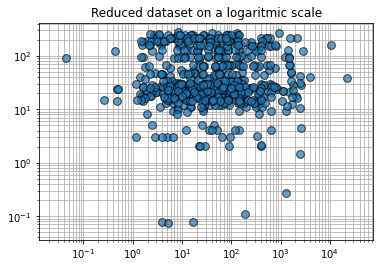

In [65]:
fig, ax = plt.subplots()
plt.grid(True,zorder=0, which="both", ls="-")
ax.scatter(red_data[:,0],red_data[:,1], s=60, alpha=0.7, edgecolors="k",zorder=3)
plt.title("Reduced dataset on a logaritmic scale")
ax.set_yscale("log")
ax.set_xscale("log")

# 2.3 Clustering!

In [24]:
import pyspark
import numpy as np
from pyspark import SparkContext, SparkConf
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
data = np.load('reduced_data_rob.npy')

In [4]:
conf = SparkConf().setAppName("Prova").setMaster("local")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 09:36:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Input:

In [82]:
points = list(zip(data[:,0], data[:,1]))
rdd = sc.parallelize(points)
cent = rdd.takeSample(withReplacement=False, num=3) # initial random centroid

Hand-written implementation of the k-means algorithm using pySpark (Map-Reduce Framework)

In [2]:
def min_distance(x, c:list):
    """Compute the distance between a point and every centroid and return the corresponding index"""
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.argmin(dist)

In [3]:
def squared_distance(x, c:list):
    """Compute the squared error between a point and every centroid and return the minimum"""
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.min(dist)

In [7]:
def k_means(rdd, cent):
    """Returns clustered data"""
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    return pd.DataFrame(belong.collect())
    
def centroids(rdd, cent):
    """Computing the new centroids through map-reduce"""
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    count = belong.countByKey()
    summation = belong.reduceByKey(lambda x, y: (x[0]+y[0],  x[1]+y[1])) # pairwise summation over the values
    cent = summation.map(lambda x: (np.array(x[1])/ count[x[0]]))
    return cent.collect()

def var(rdd, cent):
    """Total Variance"""
    accum = sc.accumulator(0)
    rdd.map(lambda x: squared_distance(x, cent)).foreach(lambda x: accum.add(x))
    return accum.value

In [9]:
def iterating(k, rdd, threshold = 10):
    """Iteratively compute the centroids until convergence (max 20 iterations)"""
    cent = rdd.takeSample(withReplacement=False, num=k) # initial random centroid    
    for i in range(20):
        prev_cent = cent
        cent = centroids(rdd, cent)
        distance = np.linalg.norm(np.array(prev_cent)-np.array(cent))
        if distance < threshold:
            break
    variance = var(rdd, cent)
    clusters = k_means(rdd, cent)
    return clusters, variance

Choosing the optimal k through the **Elbow Method**

In [83]:
sc.setLogLevel("OFF")
l = []
for k in tqdm(range(3, 11)):
    clusters, variance = iterating(k, rdd, threshold = 10)
    l.append(variance)

100%|██████████| 8/8 [16:42<00:00, 125.31s/it]                                  


<AxesSubplot:title={'center':'Elbow Method'}, xlabel='k'>

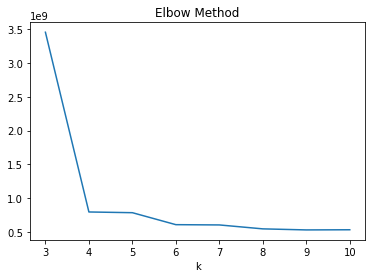

In [87]:
k = pd.DataFrame(l)
k.index = k.index + 3
k.plot(title = 'Elbow Method', legend = False, xlabel = 'k')

Choosing the optimal k through the **Silhouette Method**

In [36]:
sc.setLogLevel("OFF")
s = []
for k in tqdm(range(3, 11)):
    score = iterating(k, rdd, threshold = 10)
    s.append(silhouette_score(data, score[0][0]))

100%|██████████| 8/8 [20:47<00:00, 155.97s/it]                                  


<AxesSubplot:title={'center':'Silhouette Method'}, xlabel='k'>

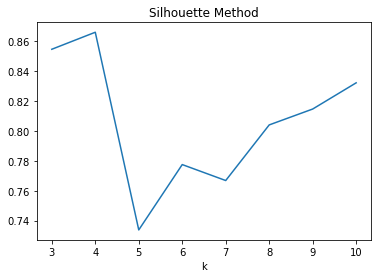

In [38]:
k = pd.DataFrame(s)
k.index = k.index + 3
k.plot(title = 'Silhouette Method', legend = False, xlabel = 'k')

Both methods returns **4** as the **optimal value for k**

In [102]:
sc.setLogLevel("OFF")
clusters, variance = iterating(4, rdd)

In [103]:
clusters['x'] = clusters[1].apply(lambda x: x[0])
clusters['y'] = clusters[1].apply(lambda x: x[1])
clusters.rename({0: 'Color'}, inplace = True, axis = 1)

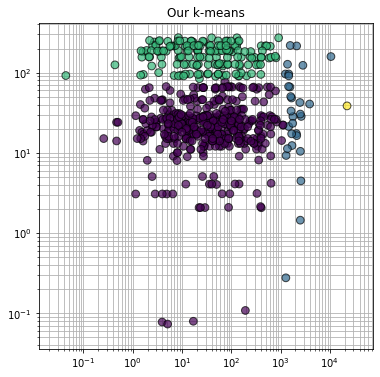

In [125]:
fig, ax = plt.subplots(figsize = (6,6))
plt.grid(True,zorder=0, which="both", ls="-")
ax.scatter(data[:,0], data[:,1], s=60, alpha=0.7, edgecolors="k", zorder=3, c=clusters.Color)
plt.title("Our k-means")
ax.set_yscale("log")
ax.set_xscale("log")

Already implemented version of K-means++ (from the scikit-learn library):

In [116]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='random').fit_predict(data)
kmeanspp = KMeans(n_clusters=4, init='k-means++').fit_predict(data)

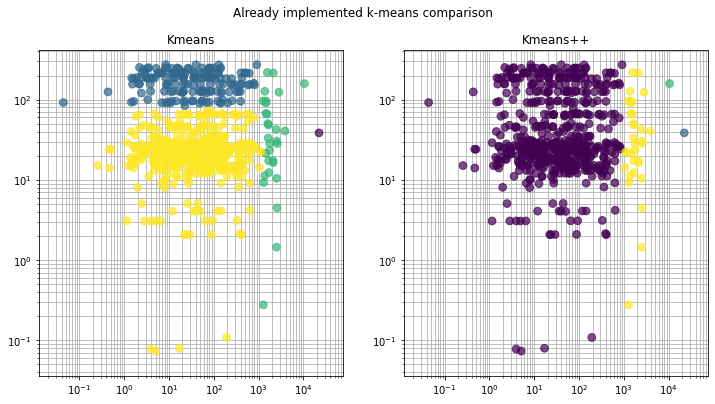

In [129]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle('Already implemented k-means comparison')

ax[0].grid(True,zorder=0, which="both", ls="-")
ax[0].scatter(data[:,0], data[:,1], s=60, alpha=0.7, zorder=3, c=kmeans)
ax[0].set_title('Kmeans')
ax[0].set_yscale("log")
ax[0].set_xscale("log")

ax[1].grid(True,zorder=0, which="both", ls="-")
ax[1].scatter(data[:,0], data[:,1], s=60, alpha=0.7, zorder=3, c=kmeanspp)
ax[1].set_title('Kmeans++')
ax[1].set_yscale("log")
ax[1].set_xscale("log")

The main differences between our implementation of _K-means_ and the _K-means++_ from scikit-learn is given by the differences in the algorithms themselves.\
As we can see form the scatter plot above (left), our work is consistent with the _K-means_ from scikit-learn.

## 2.4 Analysing your results!

Now we repeat the same procedures as above, but mantaining the information for each cusotmer.\
In the end, we obtain the same _new_feature_ DataFrame with a new column representing the cluster to which each customer belongs.

We can then procede with the pivot tables on:
* Number of transactions
* Most common gender
* Number of different locations

In [109]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

In [110]:
new_feature = pd.read_csv("new_feature.csv",index_col=0)
new_feature.dropna(inplace=True)
new_feature_fin = new_feature.copy()

In [111]:
features = ["MostFreqLocation","MostCommonGender","TrOver50k","TopPlaces","WithChildren"]  # all non-numeric features
for f in features:
    enc = preprocessing.LabelEncoder()
    enc.fit(new_feature[f])
    new_feature[f] = enc.transform(new_feature[f])
    #np.save(f+'.npy', enc.classes_)

In [112]:
scaler3 = RobustScaler()
scaled3 = scaler3.fit_transform(new_feature.set_index("CustomerID"))
pca = PCA(n_components=2)
red_data = pca.fit_transform(scaled3)
res = pd.DataFrame(red_data).join(new_feature["CustomerID"])
res["cluster"] = KMeans(n_clusters=4, init='random').fit_predict(red_data)

In [114]:
grouped = new_feature_fin.merge(res[["CustomerID","cluster"]], on="CustomerID")

The pivot tables:

In [115]:
table = pd.pivot_table(grouped, index=['cluster'], columns=["NumTransactions"],
                       values=['CustomerID'], aggfunc={'CustomerID': 'count'})
res = round(table.div(table.sum(axis=1), axis=0).fillna(0)*100,2)
res

CustomerID                         
NumTransactions          2      3     4     5     6
cluster                                            
0                   100.00   0.00  0.00  0.00  0.00
1                    79.27  18.04  2.36  0.18  0.15
2                    81.30  16.48  2.02  0.19  0.02
3                    77.99  20.75  0.63  0.63  0.00

In [116]:
table = pd.pivot_table(grouped, index=['cluster'], columns=["MostCommonGender"],
                       values=['CustomerID'], aggfunc={'CustomerID': 'count'})
res = round(table.div(table.sum(axis=1), axis=0).fillna(0)*100,2)
res

CustomerID       
MostCommonGender          F      M
cluster                           
0                    100.00   0.00
1                     85.52  14.48
2                     86.70  13.30
3                     82.39  17.61

In [120]:
table = pd.pivot_table(grouped, index=['cluster'], columns=["DifferentLocations"],
                       values=['CustomerID'], aggfunc={'CustomerID': 'count'})
res = round(table.div(table.sum(axis=1), axis=0).fillna(0)*100,2)
res

CustomerID                         
DifferentLocations          2      3     4     5     6
cluster                                               
0                      100.00   0.00  0.00  0.00  0.00
1                       79.27  18.04  2.36  0.18  0.15
2                       81.30  16.48  2.02  0.19  0.02
3                       77.99  20.75  0.63  0.63  0.00

# Algorithmic Question

In [45]:
from collections import Counter

N = int(input()) # number of entrances
M = int(input()) # number of students
G = int(input()) # number of guards

assigned_entrances = list(map(int, input().split())) # number of the entrance assigned to each student

# just a check over the input
if (len(assigned_entrances) != M) or (all(assigned_entrances[i] in range(1, N+1) for i in range(M)) == False):                       
    assigned_entrances = list(map(int, input().split()))

d = Counter(assigned_entrances) # counts how many students will pass through an entrance

guards = {f'{i+1}' : 0 for i in range(N)} # the values will become 1 if a guard will be assigned to the i-th entrance

if G >= N: # if the number of guards is greater or equal to the number of entrances it returns YES
    print('YES')
else:
    s = set() # to check what entrances had been already used
    
    #iterating over the list assigned entrances
    for i in range(M):
        
        #if it's the first time we encounter an entrance number 
        if assigned_entrances[i] not in s and G >= 0:
            s.add(assigned_entrances[i])
            # if there are still guards
            if G > 0:
                # we assign 1 to the corresponding key in the dictionary guards
                guards[f'{assigned_entrances[i]}'] = 1  
            # we decrease the number of available guards 
            G -= 1
            d[assigned_entrances[i]] -= 1
            
        # otherwise
        elif assigned_entrances[i] in s:
            d[assigned_entrances[i]] -= 1
            #if d[assigned_entrances[i]]=0 it means that we won't meet that number anymore, so the guard could be assigned again
            if d[assigned_entrances[i]] == 0  and G >= 0:
                G += 1
                
        # if we have no more guards left but we still haven't meet some of the numbers assigned to the students
        if G < 0 and len(s) <= len(d.keys()):
            print('NO')
            break
    
    # if we exit the loop and all the keys in the dictionary guards that are also in the counter d have values equal to 1
    # it means that all the students are in, hence there were enough guards
    if all(guards[f'{key}'] == 1 for key in d.keys()) == True:
        print('YES')
                
            

4
20
3
1 1 2 1 4 2 1 4 4 3 2 3 4 2 2 2 3 4 3 4
YES
